# Sää ja sähkö


In [1]:
import datetime as dt
import xmltodict
import pandas as pd
from catboost import Pool, CatBoostRegressor
from fmiopendata.wfs import download_stored_query
import seaborn as sns


def date_range(start_date, end_date, max_days):
    current_date = start_date
    while (end_date - current_date).days > max_days:
        chunk_end = current_date + dt.timedelta(days=max_days - 1)
        yield (current_date, chunk_end)
        current_date = chunk_end + dt.timedelta(days=1)
    yield (current_date, end_date)

# Weather data

Weather data is collected from [Finnish Meteorological Institute open data](https://en.ilmatieteenlaitos.fi/open-data) with [`fmiopendata`](https://github.com/pnuu/fmiopendata) Python library.


<Axes: >

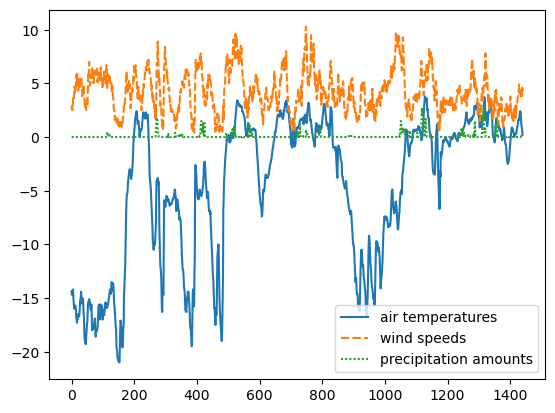

In [2]:
start_date = dt.date(2024, 1, 1)
end_date = dt.date(2024, 2, 29)

weather_data = {}
for start, end in date_range(start_date, end_date, 31):
    start_string = start.strftime("%Y-%m-%d") + "T00:00:00Z"
    end_string = end.strftime("%Y-%m-%d") + "T23:59:59Z"
    data_chunk = download_stored_query(
        "fmi::observations::weather::hourly::multipointcoverage",
        [
            "place=kaisaniemi,helsinki",
            "starttime=" + start_string,
            "endtime=" + end_string,
        ],
    ).data
    weather_data.update(data_chunk)

dates = []
air_temperatures = []
wind_speeds = []
precipitation_amounts = []

for datetime, data in weather_data.items():
    dates.append(datetime)
    air_temperatures.append(data["Helsinki Kaisaniemi"]["Air temperature"]["value"])
    wind_speeds.append(data["Helsinki Kaisaniemi"]["Wind speed"]["value"])
    precipitation_amounts.append(
        data["Helsinki Kaisaniemi"]["Precipitation amount"]["value"]
    )

weather_df = pd.DataFrame(
    {
        "datetime": dates,
        "air temperatures": air_temperatures,
        "wind speeds": wind_speeds,
        "precipitation amounts": precipitation_amounts,
    }
)

sns.lineplot(weather_df)

# Energy data

Energy data is obtained from [ENTSO-E (European Network of Transmission System Operators for Electricity) API](https://transparency.entsoe.eu/load-domain/r2/totalLoadR2/show).


Not enough energy data for 2024-03-04 01:00:00


<Axes: >

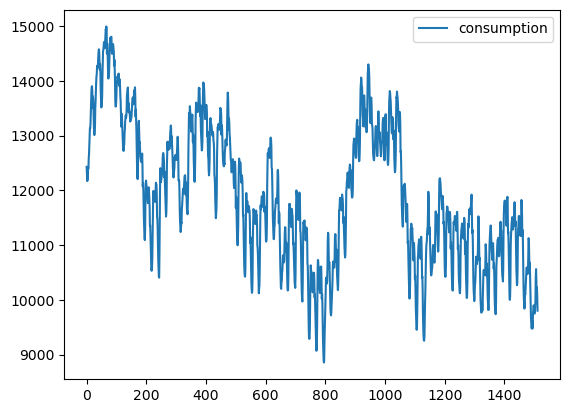

In [3]:
energy_data_file_names = ["data/ACTUAL_TOTAL_LOAD_202401010000-202501010000.xml"]
data = []
for filename in energy_data_file_names:
    with open(filename, "r") as file:
        data_string = file.read()
        yearly_data = xmltodict.parse(data_string)["GL_MarketDocument"]["TimeSeries"]
        data += yearly_data

energy_data = [day["Period"] for day in data]
hourly_means = {}

times = []
values = []

for day in energy_data:
    time = dt.datetime.strptime(
        day["timeInterval"]["start"], "%Y-%m-%dT%H:%MZ"
    ) + dt.timedelta(hours=2)
    fifteen_min_means = [int(fifteen_min["quantity"]) for fifteen_min in day["Point"]]
    if len(fifteen_min_means) != 96:
        print("Not enough energy data for", time)
        break
    i = 0
    while i < len(fifteen_min_means):
        hourly_means[time] = sum(fifteen_min_means[i : i + 4]) / 4
        times.append(time)
        values.append(sum(fifteen_min_means[i : i + 4]) / 4)
        time += dt.timedelta(hours=1)
        i += 4

energy_df = pd.DataFrame({"datetime": times, "consumption": values})
# energy_df.describe()
sns.lineplot(energy_df)

# Predictions

Predictions are made with [CatBoost library](https://catboost.ai/).


In [4]:
data_matrix = []
labels = []
day_of_week = 0
for time, weather in weather_data.items():
    if time not in hourly_means:
        print("No energy data for", time)
        continue
    data_matrix.append(
        [
            weather["Helsinki Kaisaniemi"]["Air temperature"]["value"],
            weather["Helsinki Kaisaniemi"]["Wind speed"]["value"],
            weather["Helsinki Kaisaniemi"]["Precipitation amount"]["value"],
            str(day_of_week),
        ]
    )
    if time.hour == 23:
        day_of_week = (day_of_week + 1) % 7
    labels.append(hourly_means[time])

train_data = data_matrix[: int(0.8 * len(data_matrix))]
test_data = data_matrix[int(0.8 * len(data_matrix)) :]

train_pool = Pool(train_data, labels[: int(0.8 * len(labels))], cat_features=[3])
test_pool = Pool(test_data, cat_features=[3])
model = CatBoostRegressor(iterations=2, depth=2, learning_rate=1, loss_function="RMSE")
model.fit(train_pool)
predictions = model.predict(test_pool)

print(predictions)

No energy data for 2024-01-01 00:00:00
0:	learn: 786.9149509	total: 49.7ms	remaining: 49.7ms
1:	learn: 733.4141948	total: 50.9ms	remaining: 0us
[11497.31071094 11497.31071094 11497.31071094 11497.31071094
 11497.31071094 11497.31071094 11497.31071094 11497.31071094
 11497.31071094 11497.31071094 11497.31071094 11497.31071094
 10830.04801044 10830.04801044 11041.38501496 11049.98607844
 11049.98607844 11049.98607844 11049.98607844 12592.64884998
 12592.64884998 12592.64884998 12592.64884998 12592.64884998
 11049.98607844 11049.98607844 11497.31071094 11049.98607844
 11049.98607844 11049.98607844 11049.98607844 11049.98607844
 11049.98607844 11049.98607844 11497.31071094 11497.31071094
 11497.31071094 11049.98607844 11049.98607844 11049.98607844
 11049.98607844 11049.98607844 11497.31071094 11049.98607844
 11497.31071094 11049.98607844 11497.31071094 11049.98607844
 11049.98607844 11497.31071094 11049.98607844 11497.31071094
 11049.98607844 11497.31071094 11049.98607844 11049.98607844
 1